In [1]:
import chess.pgn
import pandas as pd
import numpy as np

## A) Exemple de lecture d'une game partie au format PGN

In [2]:
with open("game_data_2013_01.pgn") as pgn_file:
    game = chess.pgn.read_game(pgn_file)

print(game.headers)
print(game.mainline_moves())
print(str(game.mainline_moves()))

Headers(Event='Rated Classical game', Site='https://lichess.org/j1dkb5dw', Date='????.??.??', Round='?', White='BFG9k', Black='mamalak', Result='1-0', UTCDate='2012.12.31', UTCTime='23:01:03', WhiteElo='1639', BlackElo='1403', WhiteRatingDiff='+5', BlackRatingDiff='-8', ECO='C00', Opening='French Defense: Normal Variation', TimeControl='600+8', Termination='Normal')
1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8#
1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8#


On voit bien que ce format est très peu pratique pour exploiter et tracer nos données... 

## B) Transformations d'un PGN en dataframe pour exploiter les données. Quelles features des metadatas sont à garder ?

On choisit de garder les données les plus pertinantes et notamment BlackRatingDiff, WhiteRatingDiff, Round, Date (car inclu dans UTCDate et comporte des "?")
- White
- Black
- Result
- UTCDate
- UTCTime
- WhiteElo
- BlackElo
- Opening
- TimeControl
- Termination

On crée donc un dataframe comportant ces colones et on converti un PGN en liste de dictionnaire puis en dataframe par vectorisation.

In [16]:
categories = ["White", "Black", "Result", "UTCDate", "UTCTime", "WhiteElo", "BlackElo", "ECO", "Opening", "TimeControl", "Termination"]
int_categories = ["WhiteElo", "BlackElo"]
df = pd.DataFrame(columns=tuple(categories+["Game"]))
games_list = []
NUMB_GAMES = 10000

with open("game_data_2013_01.pgn") as pgn_file:
    n_game=1
    game = chess.pgn.read_game(pgn_file)
    while game and n_game < NUMB_GAMES :
        entry = {c:game.headers.get(c,"") for c in categories}
        games_list.append(entry) #On ajoute le nouveau dictionnaire à la liste de dictionnaires.
        n_game += 1
        game = chess.pgn.read_game(pgn_file)

df = pd.DataFrame(games_list)
df

,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,ECO,Opening,TimeControl,Termination
0,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,C00,French Defense: Normal Variation,600+8,Normal
1,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal
2,Kozakmamay007,VanillaShamanilla,1-0,2012.12.31,23:03:15,1643,1747,C50,Four Knights Game: Italian Variation,420+17,Normal
3,Naitero_Nagasaki,800,0-1,2012.12.31,23:04:57,1824,1973,B12,Caro-Kann Defense: Goldman Variation,60+1,Normal
4,nichiren1967,Naitero_Nagasaki,0-1,2012.12.31,23:02:37,1765,1815,C00,French Defense: La Bourdonnais Variation,60+1,Normal
...,...,...,...,...,...,...,...,...,...,...,...
9994,TwoKings,akb,0-1,2013.01.03,17:53:16,1425,1404,C48,Four Knights Game: Spanish Variation,720+0,Time forfeit
9995,ChikiPuki,Pringao28,1-0,2013.01.03,17:53:27,1636,1389,C23,Bishop's Opening,60+0,Normal
9996,Pringao28,ChikiPuki,1-0,2013.01.03,17:53:39,1389,1636,B06,Modern Defense,60+0,Normal
9997,CrazyBullet,Paker,1-0,2013.01.03,17:53:59,1609,1571,A00,Van't Kruijs Opening,0+1,Time forfeit


### B.1 Changement de type des données.

In [17]:

#dtype = "str"
df.loc[:, ["White", "Black", "Result", "ECO", "Opening", "TimeControl", "Termination"]] = df.loc[:, ["White", "Black", "Result", "ECO", "Opening", "TimeControl", "Termination"]].astype(str)

base_time = pd.to_numeric(df["TimeControl"].apply(lambda x: x.split("+")[0]), errors="coerce").astype("Int64")
mask_classical = base_time >= 1800
df.loc[mask_classical, "TimeControl"] = "Classical"
mask_rapid = (base_time >= 600) & (base_time < 1800)
df.loc[mask_rapid, "TimeControl"] = "Rapid"
mask_blitz = (base_time >= 60) & (base_time < 600)
df.loc[mask_blitz, "TimeControl"] = "Blitz"
mask_bullet = base_time < 60
df.loc[mask_bullet, "TimeControl"] = "Bullet"




df["UTCDate"] = pd.to_datetime(df["UTCDate"], format='%Y.%m.%d')
df["UTCTime"] = pd.to_datetime(df["UTCTime"], format='%H:%M:%S').dt.time

#dtype = "int"
df = df[(df['WhiteElo'] != '?') & (df['BlackElo'] != '?')].copy()
df.WhiteElo = pd.to_numeric(df.WhiteElo, errors="coerce").astype("Int64")
df.BlackElo = pd.to_numeric(df.BlackElo, errors="coerce").astype("Int64")

df = df[df["TimeControl"] != "-"].copy()

df



,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,ECO,Opening,TimeControl,Termination
0,BFG9k,mamalak,1-0,2012-12-31,23:01:03,1639,1403,C00,French Defense: Normal Variation,Rapid,Normal
1,Desmond_Wilson,savinka59,1-0,2012-12-31,23:04:12,1654,1919,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Blitz,Normal
2,Kozakmamay007,VanillaShamanilla,1-0,2012-12-31,23:03:15,1643,1747,C50,Four Knights Game: Italian Variation,Blitz,Normal
3,Naitero_Nagasaki,800,0-1,2012-12-31,23:04:57,1824,1973,B12,Caro-Kann Defense: Goldman Variation,Blitz,Normal
4,nichiren1967,Naitero_Nagasaki,0-1,2012-12-31,23:02:37,1765,1815,C00,French Defense: La Bourdonnais Variation,Blitz,Normal
...,...,...,...,...,...,...,...,...,...,...,...
9994,TwoKings,akb,0-1,2013-01-03,17:53:16,1425,1404,C48,Four Knights Game: Spanish Variation,Rapid,Time forfeit
9995,ChikiPuki,Pringao28,1-0,2013-01-03,17:53:27,1636,1389,C23,Bishop's Opening,Blitz,Normal
9996,Pringao28,ChikiPuki,1-0,2013-01-03,17:53:39,1389,1636,B06,Modern Defense,Blitz,Normal
9997,CrazyBullet,Paker,1-0,2013-01-03,17:53:59,1609,1571,A00,Van't Kruijs Opening,Bullet,Time forfeit


### B.2 Nouvelle indexation par elo des parties.

Cela nous permet notamment de connaitre la fourchette d'élo de notre set de parties 

In [18]:
MoyenneElo = pd.Series(df.WhiteElo + df.BlackElo) / 2 

df.set_index(MoyenneElo, inplace=True)
df = df.sort_index()



### B.3 Modification de la notation de victoire.

Pour plus de clareté et en cohérence avec le dtype "str"

In [19]:
df.loc[(df["Result"] != "1/2-1/2") & (df["Result"] != "0-1") & (df["Result"] != "1-0") , "Result"] = np.nan
df.loc[df["Result"] == "1-0", "Result"] = "Victoire des Blancs" #on utilise .loc[ligne, colone] que l'on modifie
df.loc[df["Result"] == "0-1", "Result"] = "Victoire des Noirs"
df.loc[df["Result"] == "1/2-1/2", "Result"] = "Partie nulle"

df["Result"]

989.5      Victoire des Noirs
1019.5    Victoire des Blancs
1019.5     Victoire des Noirs
1044.5    Victoire des Blancs
1063.5    Victoire des Blancs
                 ...         
2104.0     Victoire des Noirs
2117.0    Victoire des Blancs
2124.5    Victoire des Blancs
2129.0    Victoire des Blancs
2155.0     Victoire des Noirs
Name: Result, Length: 9953, dtype: object

### B.4 Fusion des colones UTCDate et UTCTime en une colone Time.

In [20]:
df["TIME"] = pd.to_datetime(df["UTCDate"].astype(str) + " " + df["UTCTime"].astype(str))
df.drop(columns=["UTCDate", "UTCTime"], inplace=True)
df


,White,Black,Result,WhiteElo,BlackElo,ECO,Opening,TimeControl,Termination,TIME
989.5,kingofchess,nike_the_bullet,Victoire des Noirs,1011,968,A20,English Opening: King's English Variation,Blitz,Normal,2013-01-03 13:40:39
1019.5,nike_the_bullet,kingofchess,Victoire des Blancs,891,1148,B10,Caro-Kann Defense,Blitz,Normal,2013-01-03 13:40:22
1019.5,kingofchess,nike_the_bullet,Victoire des Noirs,1148,891,C20,King's Pawn Game,Blitz,Normal,2013-01-03 13:40:07
1044.5,rohirims,nike_the_bullet,Victoire des Blancs,1145,944,A00,Barnes Opening: Walkerling,Blitz,Normal,2013-01-03 12:05:41
1063.5,writinggambler,Viktoriya,Victoire des Blancs,1102,1025,D00,"Queen's Pawn Game: Levitsky Attack, Welling Va...",Classical,Normal,2013-01-01 03:22:48
...,...,...,...,...,...,...,...,...,...,...
2104.0,ostrak11,Ghost_Lombardi,Victoire des Noirs,2071,2137,E20,Nimzo-Indian Defense,Blitz,Time forfeit,2013-01-01 17:20:39
2117.0,chert843,jhipolito,Victoire des Blancs,2180,2054,B12,Caro-Kann Defense: Advance Variation,Blitz,Normal,2013-01-02 10:17:54
2124.5,ostrak11,Madland91,Victoire des Blancs,2037,2212,D45,Semi-Slav Defense: Normal Variation,Blitz,Normal,2013-01-02 22:51:13
2129.0,ObviousEngineUser,Ghost_Lombardi,Victoire des Blancs,2114,2144,E32,Nimzo-Indian Defense: Classical Variation,Blitz,Normal,2013-01-01 20:53:59


## C) Exploitation de la dataframe 

### C.1 Quel est le joueur le plus actif ?

In [8]:
joueurs = pd.Series(pd.concat([df.White, df.Black])) #On somme les parties des blancs et des noirs
joueurs.value_counts()[:10]


ChikiPuki            318
t4nk                 258
WormHole             195
F1_ALONSO_FERRARI    176
cheesedout           168
nichiren1967         162
jhipolito            141
Atomicangel          137
kent777              134
oilmanesh            114
Name: count, dtype: int64

### C.2 Les blancs gagnent ils plus souvant que les noirs ?

Result
Victoire des Blancs    5147
Victoire des Noirs     4507
Partie nulle            299
Name: count, dtype: int64

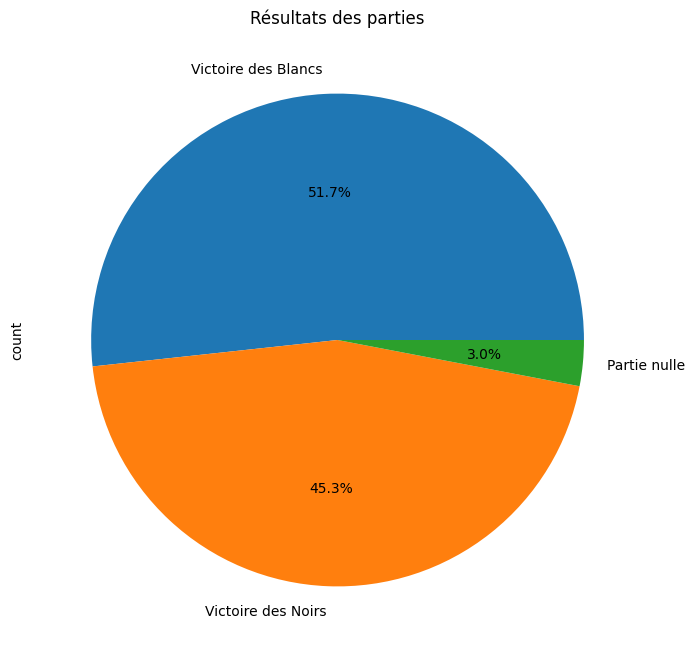

In [21]:
df.Result.value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), title="Résultats des parties")
df.Result.value_counts()

### C.3 Quel est le format de temps le plus joué sur Lichess ?

TimeControl
Blitz        7939
Rapid        1391
Bullet        550
Classical      73
Name: count, dtype: int64

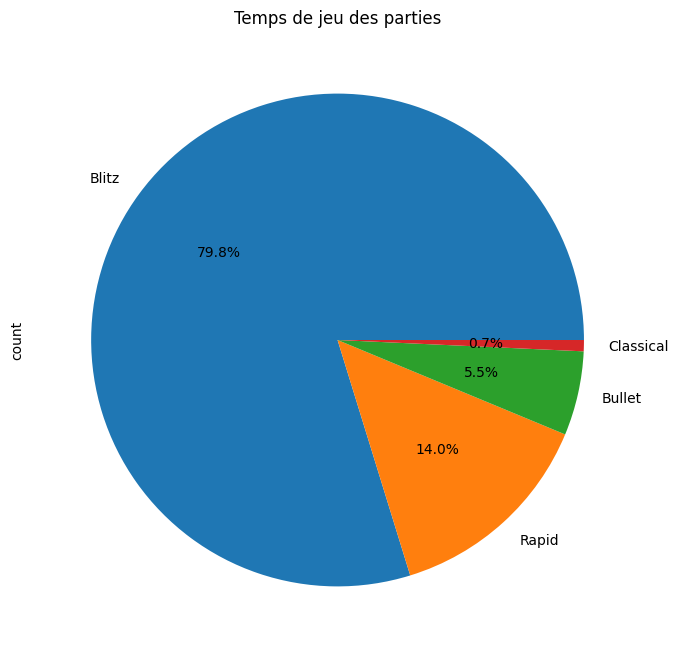

In [11]:
df = df[df["TimeControl"] != "-"]
df.TimeControl.value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), title="Temps de jeu des parties")
df.TimeControl.value_counts()



### C.4 Quel est la répartition d'élo dans les joueurs ?

<Axes: ylabel='Frequency'>

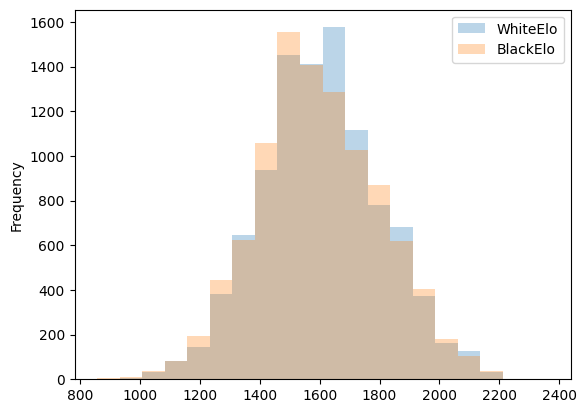

In [ ]:
import matplotlib.pyplot as plt
df[["WhiteElo","BlackElo"]].plot.hist(bins=20, alpha=0.3)

<Axes: title={'center': 'Niveau des blancs'}, ylabel='count'>

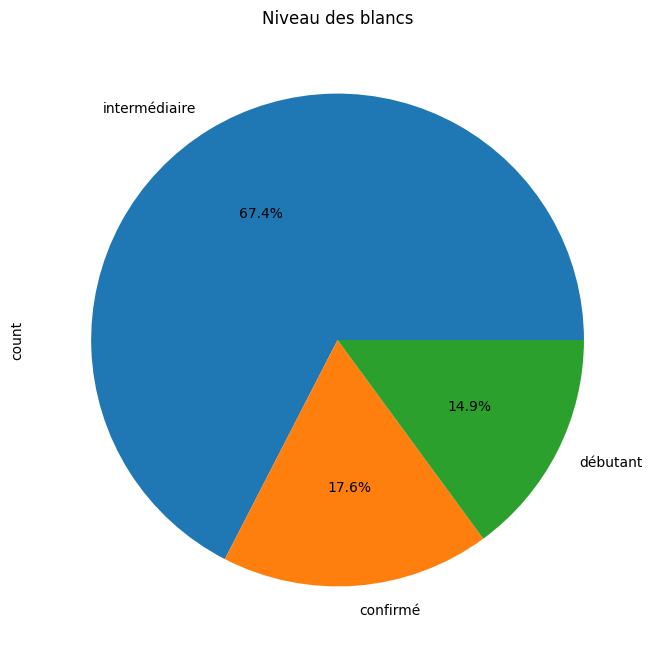

In [34]:
df["niveau_des_blancs"] = df.WhiteElo.apply(lambda x: "débutant" if x < 1400 else "intermédiaire" if x < 1800 else "confirmé").copy()
df.niveau_des_blancs.value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), title="Niveau des blancs")

On choisit de prendre 3 plages élo : une de moins de 1400, une de 1400 à 1800 et une de plus de 1800

### C.4 Les ouvertures les plus jouées...

On regroupe d'abord les variantes d'ouvertures qui sont issues da le même ligne principale (francaise par exemple). Sinon on obtient en première place des ouvertures inconnues très peu joués en absolue mais beaucoup par rapport à certaines variantes des grandes ouvertures classiques.

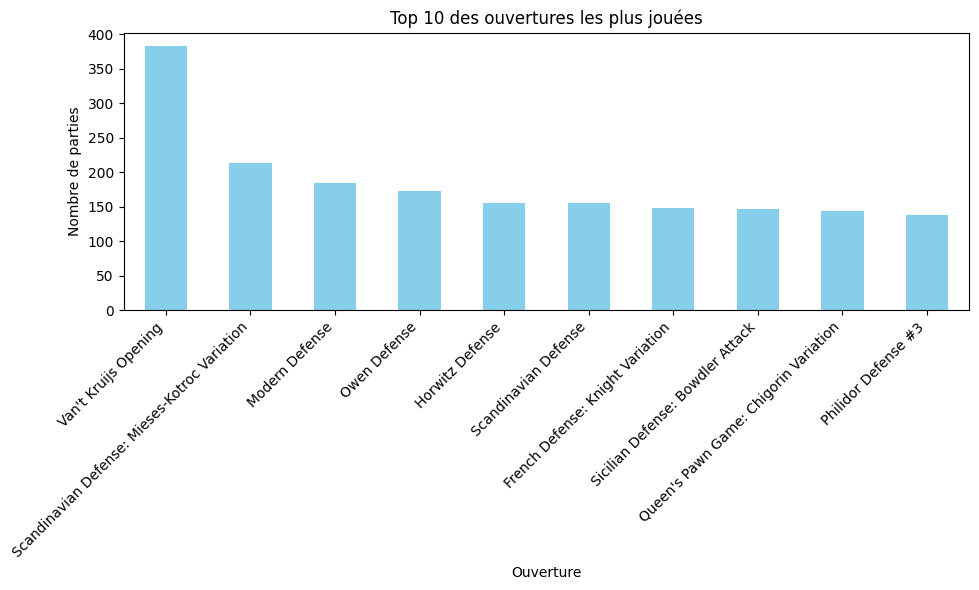

In [55]:
top_openings = df['Opening'].value_counts().head(10)

# Trace le bar plot
top_openings.plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title("Top 10 des ouvertures les plus jouées")
plt.xlabel("Ouverture")
plt.ylabel("Nombre de parties")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

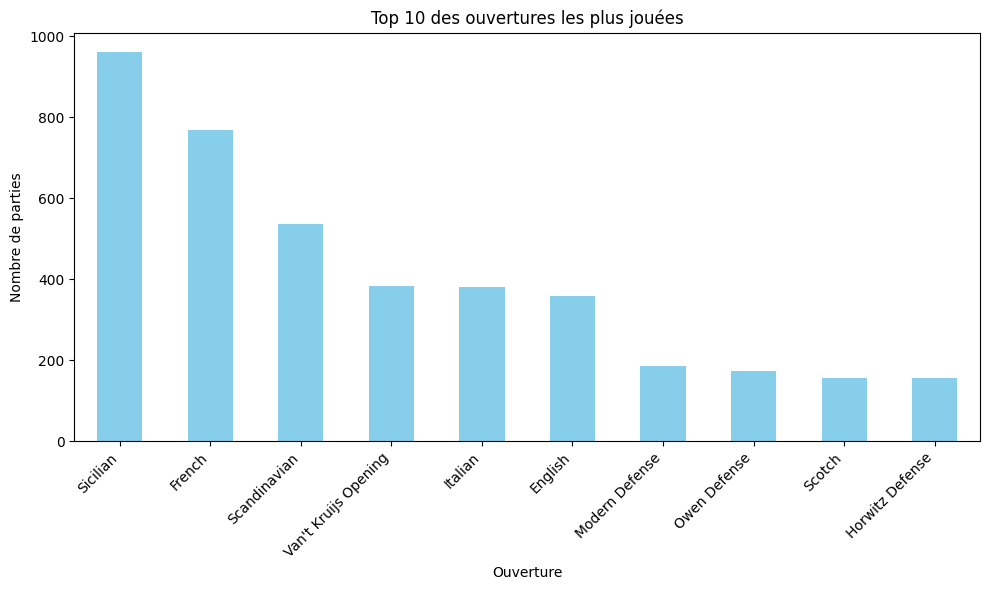

In [58]:

df["Opening_simplified"] = df["Opening"].copy()

df.loc[df["Opening"].str.contains("French", case=False, na=False), "Opening_simplified"] = "French"
df.loc[df["Opening"].str.contains("Sicilian", case=False, na=False), "Opening_simplified"] = "Sicilian"
df.loc[df["Opening"].str.contains("Queens Gambit", case=False, na=False), "Opening_simplified"] = "Queens Gambit"
df.loc[df["Opening"].str.contains("Spanish", case=False, na=False), "Opening_simplified"] = "Spanish"
df.loc[df["Opening"].str.contains("Italian", case=False, na=False), "Opening_simplified"] = "Italian"
df.loc[df["Opening"].str.contains("English", case=False, na=False), "Opening_simplified"] = "English"
df.loc[df["Opening"].str.contains("Scotch", case=False, na=False), "Opening_simplified"] = "Scotch"
df.loc[df["Opening"].str.contains("Kings Indian", case=False, na=False), "Opening_simplified"] = "Kings Indian"
df.loc[df["Opening"].str.contains("Queens Indian", case=False, na=False), "Opening_simplified"] = "Queens Indian"
df.loc[df["Opening"].str.contains("Nimzo Indian", case=False, na=False), "Opening_simplified"] = "Nimzo Indian"
df.loc[df["Opening"].str.contains("Grunfeld", case=False, na=False), "Opening_simplified"] = "Grunfeld"
df.loc[df["Opening"].str.contains("Dutch", case=False, na=False), "Opening_simplified"] = "Dutch"
df.loc[df["Opening"].str.contains("Benoni", case=False, na=False), "Opening_simplified"] = "Benoni"
df.loc[df["Opening"].str.contains("Scandinavian", case=False, na=False), "Opening_simplified"] = "Scandinavian"
top_openings_2 = df['Opening_simplified'].value_counts().head(10)
top_openings_2.plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title("Top 10 des ouvertures les plus jouées")
plt.xlabel("Ouverture")
plt.ylabel("Nombre de parties")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Différentes varaiantes de la même ouverture sont comptées plusieurs fois.